In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from watson_developer_cloud import VisualRecognitionV3

In [4]:
from zipfile import ZipFile
import os
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import numpy as np
import pandas

In [138]:
API_KEY = os.getenv('API_KEY') or 'ENTER YOUR API KEY HERE'

In [144]:
class PositiveClass:
    def __init__(self, class_name, tmpdir, urls):
        self.tmpdir = tmpdir
        self.class_name = class_name
        self.urls = urls
        
    def name(self):
        return self.class_name

    def path(self):
        return os.path.join(self.tmpdir.name,
                            "{0}_positive_examples.zip".format(self.name()))
        
    def zipfile(self):
        output_zipfile_name = self.path()
        if os.path.isfile(output_zipfile_name):
            return output_zipfile_name
        
        with ZipFile(output_zipfile_name, mode="w") as output_zip:
            for image in self.urls:
                with open(image, 'rb') as imagefile:
                    arc_name = os.path.basename(image)
                    output_zip.writestr(arc_name, imagefile.read())
        return output_zipfile_name

class NegativeClass(PositiveClass):
    def __init__(self, tmpdir, urls):
        super().__init__("negative", tmpdir, urls)
        
    def path(self):
        return os.path.join(self.tmpdir.name,"negative_examples.zip")
    
def desc_stats(numbers):
    return { 'std dev': np.std(numbers),
    'mean': np.mean(numbers),
     'min': np.min(numbers),
     'max': np.max(numbers)
    }

In [56]:
tempDir = TemporaryDirectory()

In [57]:
os.listdir("images")

['beagle', 'goldenretriever', 'negatives']

In [225]:
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

base_path_gr = "./images/goldenretriever/"
train_gr, test_gr = train_test_split(os.listdir(base_path_gr))
test_gr_images = [os.path.join(base_path_gr,x) for x in test_gr]

base_path_beagle = "./images/beagle/"
train_beagle, test_beagle = train_test_split(os.listdir(base_path_beagle))
test_beagle_images = [os.path.join(base_path_beagle,x) for x in test_beagle]

base_path_negative = "./images/negatives/"
train_negative = os.listdir(base_path_negative)

gr = PositiveClass("golden", tempDir, [os.path.join(base_path_gr,x) for x in train_gr])
beagle = PositiveClass("beagle", tempDir, [os.path.join(base_path_beagle,x) for x in train_beagle])

negative = NegativeClass(tempDir, [os.path.join(base_path_negative,x) for x in train_negative])

In [111]:
vr = VisualRecognitionV3(version='2017-01-31', api_key=API_KEY)
vr.list_classifiers()

{'classifiers': [{'classifier_id': 'A_1693693550',
   'name': 'A',
   'status': 'ready'},
  {'classifier_id': 'InsuranceClaims_678592656',
   'name': 'Insurance Claims',
   'status': 'ready'},
  {'classifier_id': 'integrationtestjavasdk_926252309',
   'name': 'integration-test-java-sdk',
   'status': 'ready'},
  {'classifier_id': 'MoleskineTypes_1384714916',
   'name': 'Moleskine Types',
   'status': 'ready'},
  {'classifier_id': 'DogBreeds_1068239630',
   'name': 'Dog Breeds',
   'status': 'ready'},
  {'classifier_id': 'DogBreeds_1393822968',
   'name': 'Dog Breeds',
   'status': 'ready'},
  {'classifier_id': 'SatelliteImagery_1999370438',
   'name': 'Satellite Imagery',
   'status': 'ready'},
  {'classifier_id': 'InsuranceClaims_719855639',
   'name': 'Insurance Claims',
   'status': 'ready'},
  {'classifier_id': 'InsuranceClaims_2091169112',
   'name': 'Insurance Claims',
   'status': 'ready'},
  {'classifier_id': 'DogBreeds_1746679274',
   'name': 'Dog Breeds',
   'status': 'ready'

In [80]:
grzip = open(gr.zipfile(), 'rb')
beaglezip = open(beagle.zipfile(), 'rb')
negativezip = open(negative.zipfile(), 'rb')

created_id = vr.create_classifier(golden_positive_examples=grzip,
                                  beagle_positive_examples=beaglezip,
                                  negative_examples=negativezip,
                                  name="POC_two")

In [91]:
my_classifier_id = created_id["classifier_id"]

while vr.get_classifier(created_id["classifier_id"])['status'] == 'training':
    sleep(10)

created_id

{'classes': [{'class': 'golden'}, {'class': 'beagle'}],
 'classifier_id': 'POC_two_339503406',
 'created': '2017-05-15T03:11:36.664Z',
 'name': 'POC_two',
 'owner': '58b61352-678c-44d1-9f40-40edf4ea8d19',
 'status': 'training'}

In [226]:
%%time
test_results = []

test_image_files = test_beagle_images

for image_file in test_image_files:
    with open(image_file,'rb') as ifile:
        result = vr.classify(images_file=ifile, classifier_ids=[my_classifier_id,'default'],threshold=0.8)
        test_results.append(result)

CPU times: user 296 ms, sys: 26.3 ms, total: 322 ms
Wall time: 37.7 s


In [218]:
with open(test_image_files[0], 'rb') as ifile:
    print(vr.classify(images_file=ifile, classifier_ids=[my_classifier_id,'default'],threshold=0.8))

{'custom_classes': 2, 'images': [{'classifiers': [{'classes': [{'class': 'beagle', 'score': 0.919257}], 'classifier_id': 'POC_two_339503406', 'name': 'POC_two'}, {'classes': [{'class': 'beagle dog', 'score': 0.872, 'type_hierarchy': '/domestic animal/beagle dog'}, {'class': 'dog', 'score': 0.961}, {'class': 'domestic animal', 'score': 0.961}, {'class': 'animal', 'score': 0.961}, {'class': 'tan color', 'score': 0.995}], 'classifier_id': 'default', 'name': 'default'}], 'image': './images/beagle/beagle-1069765_960_720.jpg'}], 'images_processed': 1}


In [227]:
class_scores = {}
# DANGER WILL ROBINSON:  the following is a set of
# actions that flatten the list of classes returned by the classifiers
scores_list = list(itertools.chain(*[m['classes'] 
                       for m 
                       in list(itertools.chain(*[z[0]['classifiers'] 
                                                 for z 
                                                 in [u['images'] 
                                                     for u 
                                                     in test_results]]))]))
for y in scores_list:
    if y['class'] in class_scores:
        class_scores[y['class']].append(y['score'])
    else:
        class_scores[y['class']]=[y['score']]

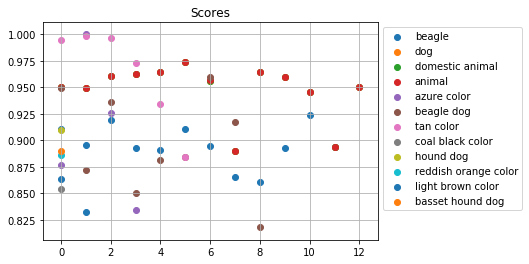

,animal,azure color,basset hound dog,beagle,beagle dog,coal black color,dog,domestic animal,hound dog,light brown color,reddish orange color,tan color
max,0.974000,1.000000,0.89,0.923970,0.960000,0.854,0.974000,0.974000,0.91,0.8630,0.886,0.998000
mean,0.947846,0.909250,0.89,0.895846,0.896333,0.854,0.947769,0.947769,0.91,0.8475,0.886,0.963500
min,0.890000,0.834000,0.89,0.860347,0.818000,0.854,0.890000,0.890000,0.91,0.8320,0.886,0.884000
std dev,0.024961,0.061682,0.00,0.018282,0.044833,0.000,0.024934,0.024934,0.00,0.0155,0.000,0.042003


In [228]:
labels = class_scores.keys()

for l in labels:
    plt.scatter(range(0,len(class_scores[l])), class_scores[l], label=l)

plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.title("Scores")
plt.show()

pandas.DataFrame(dict([(x,desc_stats(class_scores[x])) for x in labels]))

In [229]:
updated_gr = PositiveClass("golden", tempDir, [os.path.join(base_path_gr,x) for x in test_gr])

update_gr_file = open(updated_gr.zipfile(),'rb')
vr.update_classifier(classifier_id=my_classifier_id, golden_positive_examples=update_gr_file)

{'classes': [{'class': 'golden'}, {'class': 'beagle'}],
 'classifier_id': 'POC_two_339503406',
 'created': '2017-05-15T03:11:36.664Z',
 'name': 'POC_two',
 'owner': '58b61352-678c-44d1-9f40-40edf4ea8d19',
 'status': 'retraining'}